# CP 8 Aprendizaje de Máquinas
---

## Redes Neuronales

## Configuración

Primero, importemos algunos módulos comunes, asegurémonos de que MatplotLib trace figuras en línea. También verificamos que Python 3.5 o posterior esté instalado (aunque Python 2.x puede funcionar, está obsoleto, por lo que le recomendamos que use Python 3 en su lugar), así como Scikit-Learn $\geq$ 0.20 y TensorFlow $\geq$ 2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


2022-05-24 16:09:40.347021: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-05-24 16:09:40.367185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-24 16:09:40.367326: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Ejercicio 1: Funciones de Activación

It is used to determine the output of neural network like yes or no. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).

The Sigmoid Function curve looks like a S-shape. Goes between 0 and 1, its formula its: $$S(z) = \dfrac{1}{1 + e^{-z}}$$

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

The ReLU is the most used activation function in the world right now. Since, it is used in almost all the convolutional neural networks or deep learning. As you can see, the ReLU is half rectified (from bottom). f(z) is zero when z is less than zero and f(z) is equal to z when z is above or equal to zero. Its formula its: $$R(z)= \max(0, z)$$ 

In [3]:

def relu(z):
    return np.maximum(0, z)

La siguiente función, calcula la derivada de una función `f` en un punto `z` con una precisión `eps` especificado.

In [4]:

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Vamos a graficar las funciones de activación más populares y sus derivadas.

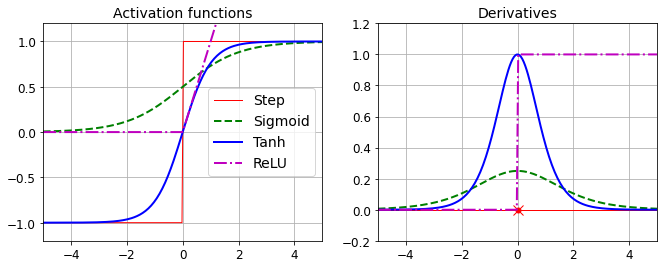

In [5]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### Ejercicio 3: Construyendo un Clasificador de Imágenes

First let's import TensorFlow and Keras.

In [6]:
import tensorflow as tf
from tensorflow import keras

Comencemos cargando el conjunto de datos MNIST de moda (`fashion_mnist`). Keras tiene una serie de funciones para cargar conjuntos de datos populares en `keras.datasets`. Sin embargo, vamos a cargar estos datos de forma local.

In [7]:
# This is how you would load (if you want use it)
# fashion_mnist = keras.datasets.fashion_mnist
# (X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

Para convertir los datos comprimidos en arrays de numpy usamos dos funciones: `load_dataset_data` y `load_dataset_labels`.

In [8]:
import gzip

In [9]:
def load_dataset_data(filename: str, num_images: int) -> np.ndarray:
    image_size = 28
    with gzip.open(filename, "r") as f:
        f.read(16)
        buf = f.read(image_size*image_size*num_images)
    data = np.frombuffer(buf, dtype=np.uint8)
    return data.reshape(num_images, image_size, image_size)


In [10]:
def load_dataset_labels(filename: str, num_images) -> np.ndarray:
    with gzip.open(filename, 'r') as f:
        f.read(8)
        buf = f.read(num_images)
        labels = np.frombuffer(buf, dtype=np.uint8)
    return labels

In [11]:
X_train_full = load_dataset_data("./resources/fashion-mnist/train-images-idx3-ubyte.gz", 60000)
X_test = load_dataset_data("./resources/fashion-mnist/t10k-images-idx3-ubyte.gz", 10000)
y_train_full = load_dataset_labels("./resources/fashion-mnist/train-labels-idx1-ubyte.gz", 60000)
y_test = load_dataset_labels("./resources/fashion-mnist/t10k-labels-idx1-ubyte.gz", 10000)

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [12]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [13]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [14]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

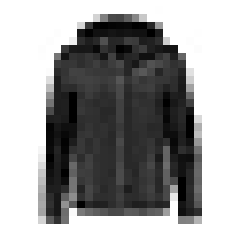

In [15]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [16]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [17]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [18]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [19]:
X_valid.shape

(5000, 28, 28)

In [20]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

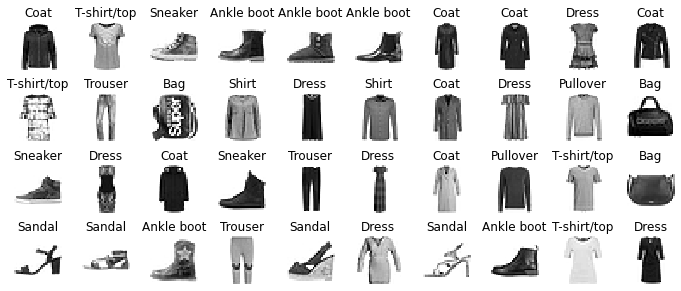

In [21]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Ahora, construyamos nuestra primera red neuronal. Para ello, creamos una instancia de la clase `keras.models.Sequential`. Esta clase tendrá una lista de capas, cada una de las cuales es una instancia de la clase `keras.layers.Layer`. Cada una de las capas de la red neuronal se pueden añadir con la función `add()`, que recibe una instancia de la clase `keras.layers.Layer`.

Para esta red neuronal vamos a crear primero una capa `Flatten` (disponible en `keras.layers.Flatten(input_shape)`) que convierte las imágenes de 28x28 pixels a una matriz de 784 pixels. Luego, creamos una capa densa (`keras.layers.Dense(units, activation='relu'`) con 300 unidades, otra con 100 unidades, ambas usando la función de activación ReLU y una última capa densa de salida, que debe tener la misma cantidad de unidades que los tipos de clases, en nuestro caso, 10, con función de activación `softmax`, tiene como salida números en el intervalo de [0, 1], representando una probabilidad de distribución.

In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

2022-05-24 16:09:47.834723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-24 16:09:47.834807: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-24 16:09:47.834829: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Loraine-Laptop): /proc/driver/nvidia/version does not exist
2022-05-24 16:09:47.835243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Cada una de las capas además pueden ser pasadas como argumentos de la inicialización del modelo secuencial mediante una lista (`keras.models.Sequential(layers: list)`).

In [23]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

Veamos las capas de nuestro modelo usando el atribtuto `layers`:

In [24]:
model.layers

La función `summary` nos hace un resumen de la estructura de nuestra red neuronal, mostrandonos las dimensiones de salida de cada capa y la cantidad de parámetros a entrenar por cada una de las capas (y la cantidad total).

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Aquellos que tengan `pydot` y `graphviz` instalados, podemos ver una imagen de la red neuronal:	

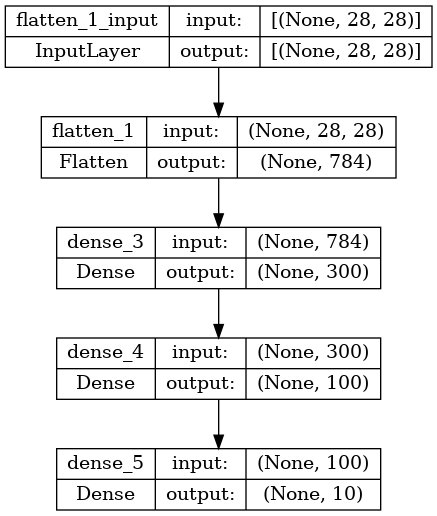

In [26]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

Cada una de las capas tiene un atributo `name`, veamos el nombre de nuestra 2da capa:

In [27]:
hidden1 = model.layers[1]
hidden1.name

'dense_3'

Mediante el `get_layer` podemos acceder a una capa de nuestro modelo a través de su nombre:

In [29]:
model.get_layer(hidden1.name) is hidden1

True

La función `get_weights` de cada una de las capas nos devuelve una matriz de numpy, cada uno de los cuales representa los pesos de la capa y un array que representan los sesgos (*bias*).

In [35]:
weights, biases = hidden1.get_weights()

Veamos la forma que tienen cada uno de estos parámetros:

In [36]:
weights

array([[ 0.05662204, -0.00591078,  0.04514027, ...,  0.04712801,
         0.07090212,  0.02642181],
       [-0.01343444, -0.00979459, -0.03589404, ..., -0.0708269 ,
        -0.029843  ,  0.07269208],
       [ 0.05506736,  0.02061594,  0.05656067, ..., -0.06958239,
         0.05419816, -0.06995671],
       ...,
       [ 0.03865241, -0.00540426,  0.06315325, ...,  0.01414862,
         0.04189529, -0.04764065],
       [ 0.03699038, -0.02260212,  0.06861617, ..., -0.04636358,
        -0.05939253, -0.02817073],
       [ 0.03209119,  0.01251768,  0.06393255, ..., -0.01518932,
        -0.01549425, -0.0718886 ]], dtype=float32)

In [37]:
weights.shape

(784, 300)

In [38]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [39]:
biases.shape

(300,)

Una vez creada nuestra red neuronal, siempre antes de hacer `fit` tenemos que definir una función de pérdida y una función de optimización (y opcionalmente una medida de rendimiento). Esto lo hacemos con la función `compile()`. Como función de pérdida vamos a usar `sparse_categorical_crossentropy`, comunmente usada en problemas de clasificación y como función de optimización vamos a usar `sgd` (*stochastic gradient descent*). Como medida de rendimiento vamos a usar `accuracy`. Corramos nuestra red neuronal con 5 epochs.

In [41]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

### Ejercicio 4: Entrenando un Clasificador de Imágenes

Ahora, vamos a entrenar a nuestro modelo usando `fit` en nuestro conjunto de datos de entrenamiento, `X_train` y `y_train`. Podemos especificar la cantidad de *epochs* (iteraciones sobre los datos para entrenar el modelo) con el parámetros `epochs` y los datos de validación usados para evaluar el modelo durante su entrenamiento mediante el parámetro `validation_data` (este es una tupla, `X_valid` y `y_valid`). 

In [59]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2289 - accuracy: 0.9175 - val_loss: 0.3243 - val_accuracy: 0.8786
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2254 - accuracy: 0.9200 - val_loss: 0.2951 - val_accuracy: 0.8950
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2215 - accuracy: 0.9202 - val_loss: 0.3296 - val_accuracy: 0.8830
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2173 - accuracy: 0.9226 - val_loss: 0.3084 - val_accuracy: 0.8902
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2141 - accuracy: 0.9227 - val_loss: 0.3028 - val_accuracy: 0.8898
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2119 - accuracy: 0.9241 - val_loss: 0.3050 - val_accuracy: 0.8886
Epoch 7/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2077 - accuracy: 0.9253 - val_loss: 0.3061 - val_accuracy:

El método `fit` devuelve una instancia del objeto `History`, que guarda información con respecto al proceso de entrenamiento. Por ejemplo:

In [60]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [61]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [62]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Grafiquemos los distintos resultados obtenidos durante el entrenamiento:

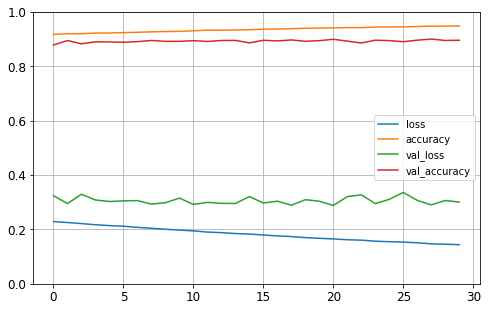

In [63]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Ejercicio 5: Evaluando un Clasificador de Imágenes

Ahora, realicemos la evaluación de nuestro modelo mediante la función `evaluate`, que recibe como argumentos los datos de prueba y sus etiquetas.

In [64]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3340 - accuracy: 0.8915


[0.3340115249156952, 0.8914999961853027]

Mediante el método `predict`, podemos obtener las predicciones de la red neuronal, que son las probabilidades de pertenenecia a cada una de las clases.

In [65]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 79ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Para predecir la clase a la que pertenece, se usa la función `np.argmax`, que nos dará el índice de la clase donde la instancia de entrenamiento tendrá más probabilidad de pertenecer.

In [66]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 26ms/step


array([9, 2, 1])

Para ver el nombre de la clase a las que pertenece, podemos indexar por el indice de la clase en la lista `class_names` (se recomienda convertirla en un array de numpy para esto):

In [68]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

Veamos cuales eran las clases reales de estas instancias de prueba (están en `y_test`):

In [70]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Veamos en una imagen cuales eran las clases reales de estas instancias de prueba:

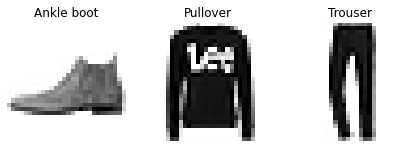

In [72]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Ejercicio 6: Regresión con MLP (_**M**ulti**L**ayer **P**erceptron_)

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing(data_home='./resources', download_if_missing=False)

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

In [ ]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
y_pred

### Ejercicio 7: API Funcional de Keras

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [ ]:
model.summary()

In [ ]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

### Ejercicio 8: Salvando y Recuperando Modelos de Keras

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

In [ ]:
model.save("my_keras_model.h5")

In [ ]:
model = keras.models.load_model("my_keras_model.h5")

In [ ]:
model.predict(X_new)

In [ ]:
model.save_weights("my_keras_weights.ckpt")

In [ ]:
model.load_weights("my_keras_weights.ckpt")